<center><h1>Time series analysis</h1></center>
<center><h2>Forecasting on a Movile Phone Dataset</h2></center>
<br>

In this Jupyter-notebook we will apply some Forecasting Methods to a Movile Phone Dataset, wich provides four Features, "Minutos pospago salientes (miles)" or pos-pay minutes on thousands, "Minutos prepago salientes (miles)" or pre-pay minutes on thousands, "Total de minutos salientes (miles)" or total numbers of minutes on thousands and finally "Periodo" wich describes the period of time to take in to account.

This notebook relies on the following imports and settings.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from datetime import datetime
from pandas.tseries.offsets import BQuarterBegin
from plotting import fanchart

In [7]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

## Mobile Phone Dataset

In [14]:
data = pd.read_csv('datasets/Telefonia_movil.csv')
data['Año'] = pd.to_datetime(data['Año'], format = '%Y')  #converting "Año" in datetime 
data['date'] = data.apply(lambda x : (x['Año'] + BQuarterBegin(x['Trimestre'])), axis = 1) 
data = data.set_index('date').drop(['Año', 'Trimestre'], axis = 1 ) #setting new column "date" as index  
data.index = data.index.to_period(freq='Q') # converting the index to quarterly period instead of dates
data.head(6)

,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
date,,,,
2013Q1,8.785.943,6582117,15368060,Ene-Mar 2013
2013Q2,9.512.689,7108640,16621329,Abr-Jun 2013
2013Q3,10.315.484,7335154,17650638,Jul-Sept 2013
2013Q4,9.809.515,6250549,16060064,Oct-Dic 2013
2014Q1,10.128.751,5799223,15927974,Ene-Mar 2013
2014Q2,10.821.463,6438071,17259534,Abr-Jun 2014


In [15]:
data['Minutos pospago salientes (miles)'] = data['Minutos pospago salientes (miles)'].str.replace(".","").astype(int)
data.drop(['Periodo'], axis = 1, inplace = True)
data.columns = ['mins_pos_pay','mins_pre_pay','total_mins']

In [16]:
data.head(4)

,mins_pos_pay,mins_pre_pay,total_mins
date,,,
2013Q1,8785943,6582117,15368060
2013Q2,9512689,7108640,16621329
2013Q3,10315484,7335154,17650638
2013Q4,9809515,6250549,16060064


## Exploratory Data Analysis

The first step in our analysis is a time series plot.  We can notice that there is a pike at 2017 first quarter on pos-pay minutes plot wich is also well defined on the total minutes plot.

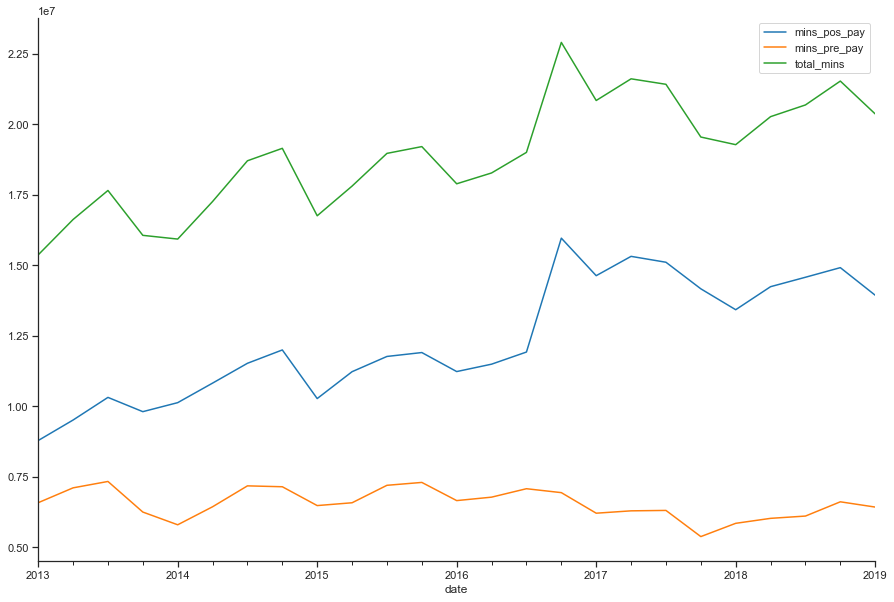

In [66]:
data[['mins_pos_pay', 'mins_pre_pay', 'total_mins']].plot()
sns.despine()

In [67]:
data.describe().round(2)

,mins_pos_pay,mins_pre_pay,total_mins
count,25.00,25.0,25.00
mean,12359295.44,6562909.4,18922204.72
std,2085582.33,516860.4,1982378.31
min,8785943.00,5380710.0,15368060.00
25%,10821463.00,6250549.0,17650638.00
50%,11905073.00,6579819.0,19001229.00
75%,14240217.00,7077838.0,20364355.00
max,15960765.00,7335154.0,22899656.00


## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [68]:
h = 4
values_index = pd.period_range(start=data.index[-1]+1, periods=h, freq='Q')
pred = pd.concat([data.tail(1)]*h)
pred.index = values_index
pred

,mins_pos_pay,mins_pre_pay,total_mins
2019Q2,13937271,6427084,20364355
2019Q3,13937271,6427084,20364355
2019Q4,13937271,6427084,20364355
2020Q1,13937271,6427084,20364355


To compute interval forecasts, we first estimate the standard deviation of the errors.

In [69]:
resid=data-data.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

mins_pos_pay    1111026.926
mins_pre_pay     510832.977
total_mins      1409600.295
dtype: float64

Using the formulas from the lecture, the interval forecasts are as below. 

In [88]:
[pred['mins_pos_pay']-stats.norm.ppf(0.975)*sigma['mins_pos_pay']*np.sqrt(np.arange(1,h+1))]

[2019Q2    1.175970e+07
 2019Q3    1.085772e+07
 2019Q4    1.016560e+07
 2020Q1    9.582125e+06
 Freq: Q-DEC, Name: mins_pos_pay, dtype: float64]

In [98]:
#Calculations of interval forecasts

intv_pos = pd.concat([pred['mins_pos_pay']-stats.norm.ppf(0.975)*sigma['mins_pos_pay']*np.sqrt(np.arange(1,h+1)), 
                      pred['mins_pos_pay']+stats.norm.ppf(0.975)*sigma['mins_pos_pay']*np.sqrt(np.arange(1,h+1))],
                      axis=1)
intv_pos.columns = [0, 1]

intv_pre = pd.concat([pred['mins_pre_pay']-stats.norm.ppf(0.975)*sigma['mins_pre_pay']*np.sqrt(np.arange(1,h+1)),
                      pred['mins_pre_pay']+stats.norm.ppf(0.975)*sigma['mins_pre_pay']*np.sqrt(np.arange(1,h+1))],
                      axis=1)
intv_pre.columns = [0, 1]

intv_total = pd.concat([pred['total_mins']-stats.norm.ppf(0.975)*sigma['total_mins']*np.sqrt(np.arange(1,h+1)),
                        pred['total_mins']+stats.norm.ppf(0.975)*sigma['total_mins']*np.sqrt(np.arange(1,h+1))],
                        axis=1)
intv_total.columns = [0, 1]

intv_pre.round(3)

,0,1
2019Q2,5425869.763,7428298.237
2019Q3,5011153.247,7843014.753
2019Q4,4692930.072,8161237.928
2020Q1,4424655.526,8429512.474


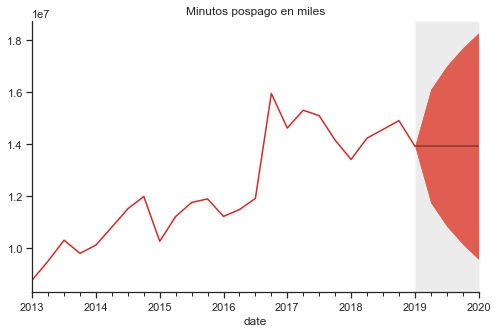

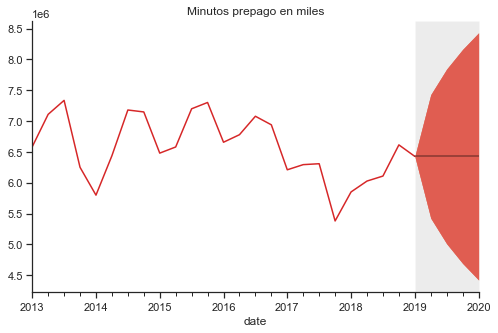

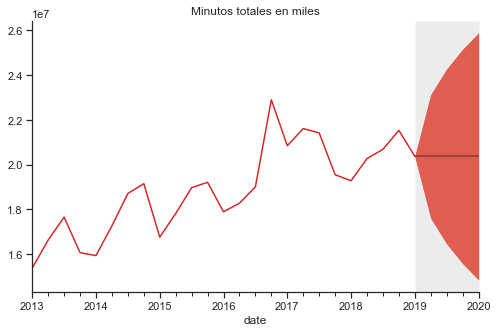

In [124]:
#Calculating prediction points as mean between later calculated interval points
point_pos = (intv_pos[0]+intv_pos[1])/2
point_pre = (intv_pre[0]+intv_pre[1])/2
point_total = (intv_total[0]+intv_total[1])/2

fig, ax1 = fanchart(data['mins_pos_pay'], point_pos, intv_pos, intv_pos, intv_pos)
ax1.set_title('Minutos pospago en miles') #Set plot title
sns.despine()
fig, ax2 = fanchart(data['mins_pre_pay'], point_pre, intv_pre, intv_pre, intv_pre)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) #For this plot we need to transform "y axis" into scientific notation
ax2.set_title('Minutos prepago en miles') #Set plot title
sns.despine()
fig, ax3 = fanchart(data['total_mins'], point_total,intv_total,intv_total,intv_total)
ax3.set_title('Minutos totales en miles') #Set plot title
sns.despine()



plt.show()

As we can see, when time passes, prediction becomes more and more unaccurate. 

## Simple exponential smoothing

The exponential smoothing functions are available since version 0.9 of statsmodels in the **tsa.
holtwinters** module. Take a look in the official [docs](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing). Also, they are improving them, so follow the news for the next release.

In [22]:
#Modeling using pos-pay minutes feature
model_pos_pay = sm.tsa.SimpleExpSmoothing(data['mins_pos_pay']).fit()
fit_pos_pay = model_pos_pay.fittedvalues
print('Summary of model training with feature "mins_pos_pay"')
display(model_pos_pay.summary())

#Modeling using pre-pay minutes feature
model_pre_pay = sm.tsa.SimpleExpSmoothing(data['mins_pre_pay']).fit()
fit_pre_pay = model_pre_pay.fittedvalues
print('Summary of model training with feature "mins_pre_pay"')
display(model_pre_pay.summary())

#Modeling using total minutes feature
model_total = sm.tsa.SimpleExpSmoothing(data['total_mins']).fit()
fit_total = model_total.fittedvalues
print('Summary of model training with feature "total_mins"')
display(model_total.summary())


Summary of model training with feature "mins_pos_pay"


Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,28393926159405.254
Optimized:,True,AIC,697.958
Trend:,None,BIC,700.396
Seasonal:,None,AICC,699.958
Seasonal Periods:,None,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,16:09:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7871933,alpha,True
initial_level,8.786e+06,l.0,True


Summary of model training with feature "mins_pre_pay"


Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,5832098079555.361
Optimized:,True,AIC,658.388
Trend:,None,BIC,660.826
Seasonal:,None,AICC,660.388
Seasonal Periods:,None,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,16:09:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4324486,alpha,True
initial_level,6.7286e+06,l.0,True


Summary of model training with feature "total_mins"


Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,43907864549324.172
Optimized:,True,AIC,708.856
Trend:,None,BIC,711.294
Seasonal:,None,AICC,710.856
Seasonal Periods:,None,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,16:09:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6030715,alpha,True
initial_level,1.5372e+07,l.0,True


Also AIC and BIC looks off so we are continue our analysis with MSE.

In [27]:
mse_pos = sm.tools.eval_measures.mse(data['mins_pos_pay'],fit_pos_pay)
print(' In-sample fit with pos-pay minutes feature:')
print(' MSE               {0:.3f}'.format(mse_pos))

mse_pre = sm.tools.eval_measures.mse(data['mins_pre_pay'],fit_pre_pay)
print(' In-sample fit with pre-pay minutes feature:')
print(' MSE               {0:.3f}'.format(mse_pre))

mse_total = sm.tools.eval_measures.mse(data['total_mins'], fit_total)
print(' In-sample fit with total minutes feature:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit with pos-pay minutes feature:
 MSE               1135757046376.210
 In-sample fit with pre-pay minutes feature:
 MSE               233283923182.214
 In-sample fit with total minutes feature:
 MSE               1756314581972.967


You can calculate AIC and BIC as follows, this time we are only doing it for total_mins feature. 

In [28]:
N = len(data['total_mins'])
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_total)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -387.901
 AIC               781.803
 BIC               785.460


Now, let's see how the smoothed data fits the original data

In [35]:
def simple_exp_plot(y, y_fit, y_label):
    fig, ax= plt.subplots();
    y.plot(label='Telefonia Móvil')
    y_fit.plot(label='Simple exponential smoothing fit', alpha=0.8)
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    ax.set_title(y_label + ' - Telefonía móvil')
    ax.set_xticks([], minor=True) 
    plt.legend(loc='best')
    sns.despine()
    plt.show()

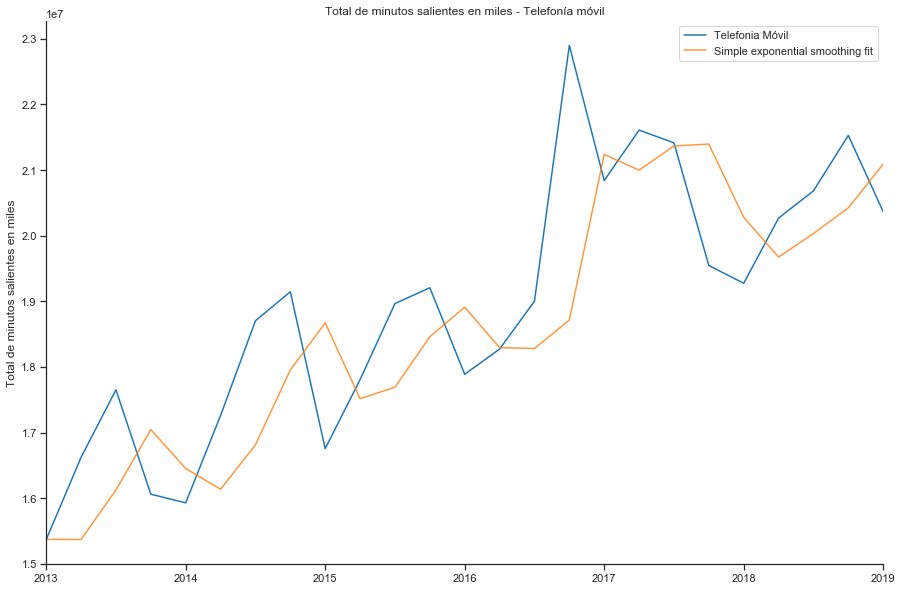

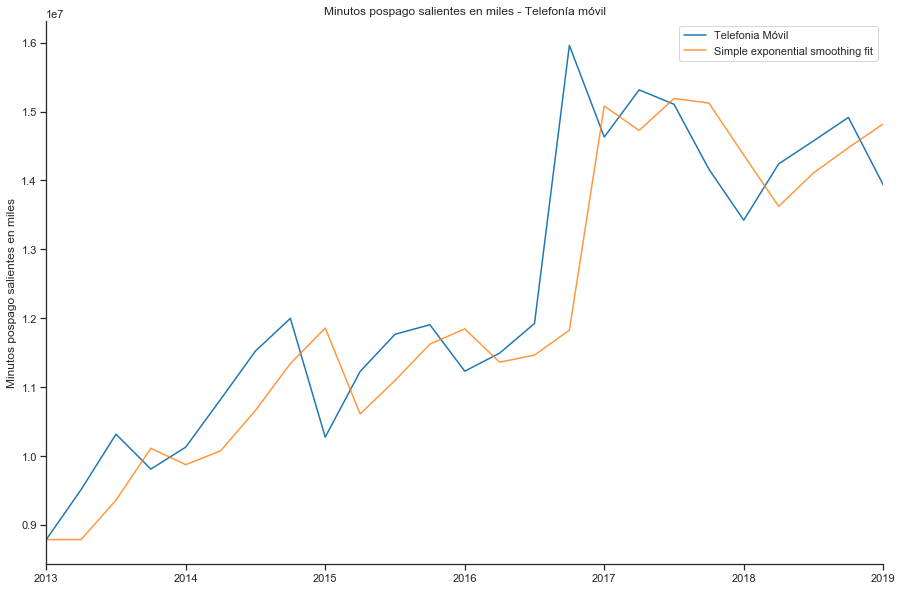

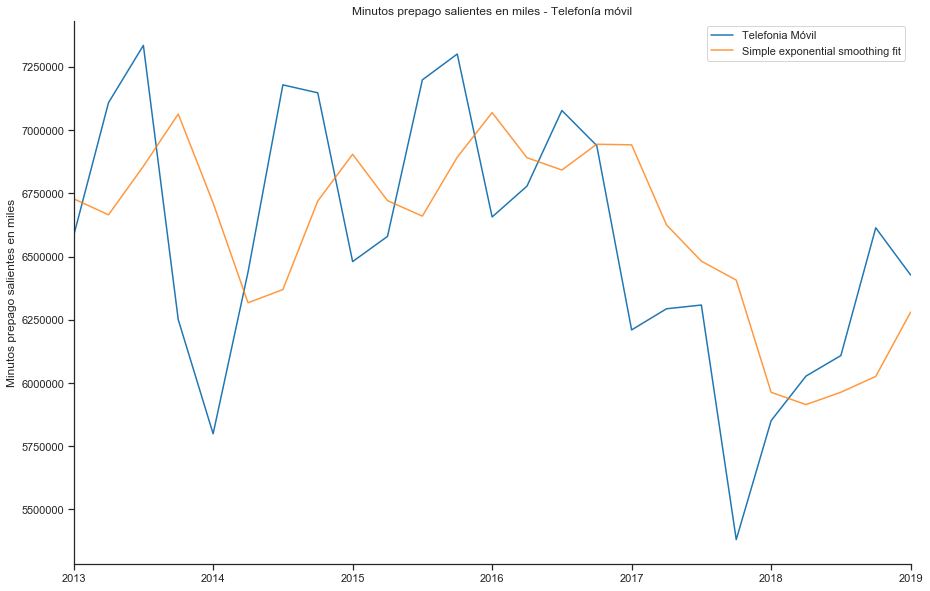

In [48]:
simple_exp_plot(data['total_mins'], fit_total, 'Total de minutos salientes en miles')
simple_exp_plot(data['mins_pos_pay'], fit_pos_pay, 'Minutos pospago salientes en miles')
simple_exp_plot(data['mins_pre_pay'], fit_pre_pay, 'Minutos prepago salientes en miles')

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

In [45]:
resid_pos = data['mins_pos_pay'] - fit_pos_pay 
resid_pre = data['mins_pre_pay'] - fit_pre_pay
resid_total = data['total_mins'] - fit_total

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (no patterns encountered), and pos-pay and total minutes feature are non-Gaussian, we cannot say the same for pre-pay feature. 

In [52]:
def resid_plot(resid, title):
    fig, ax= plt.subplots()
    resid.plot()
    ax.set_xlabel('')
    ax.set_xticks([], minor=True) 
    ax.set_title(title)
    sns.despine()
    plt.show()

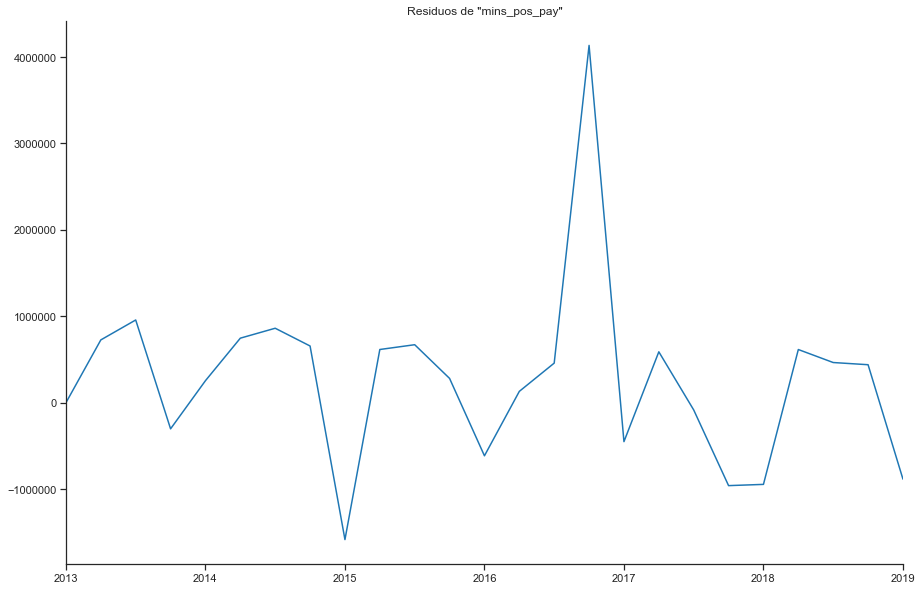

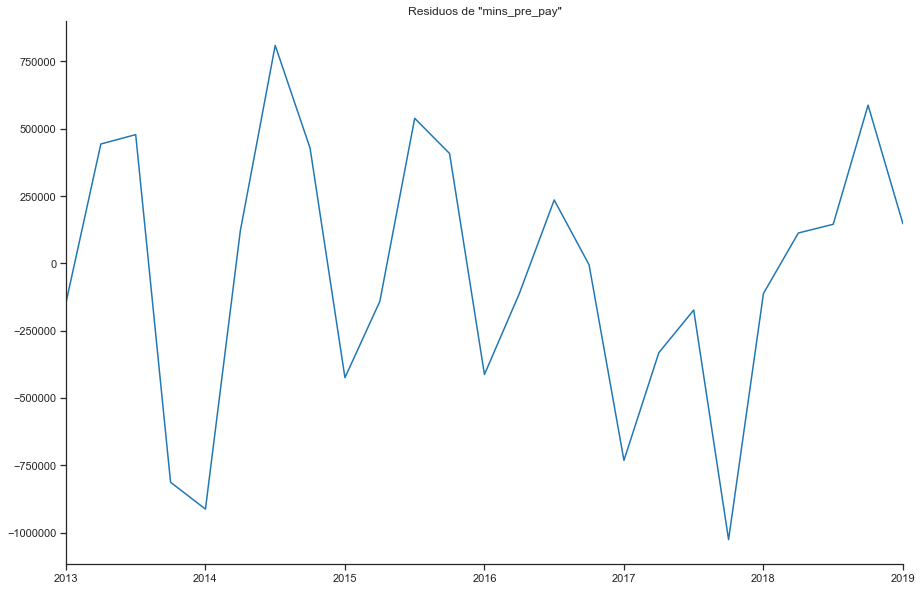

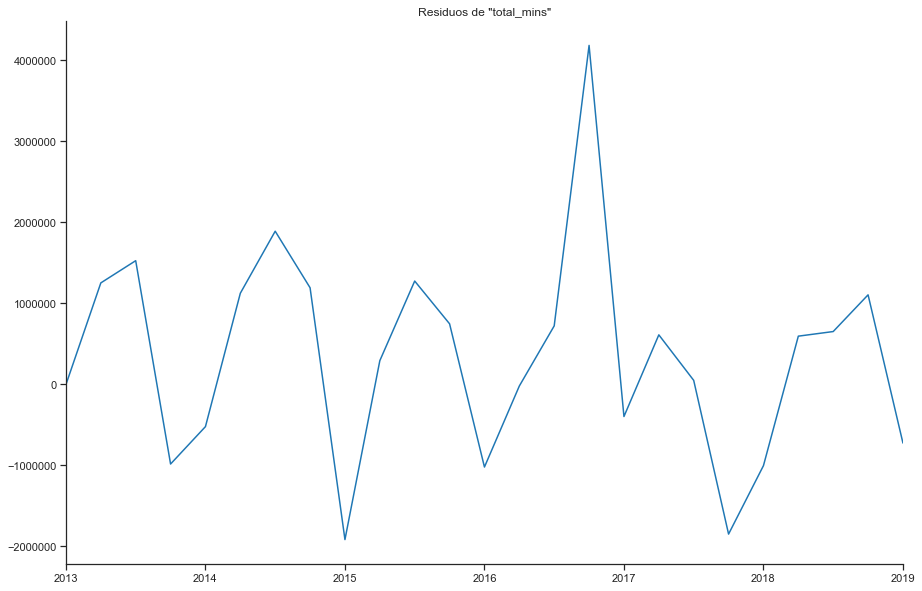

In [53]:
resid_plot(resid_pos, 'Residuos de "mins_pos_pay"')
resid_plot(resid_pre, 'Residuos de "mins_pre_pay"')
resid_plot(resid_total, 'Residuos de "total_mins"')

Next is the residual ACF (AutoCorrelation Function) plot aka correlogram. In general Confidence Inteval is set to a 95% suggesting that correlation values outside of this shadowly plot are very likely a correlation and not a statistical fluke.

In [61]:
def correlogram_plot(resid):
    fig, ax = plt.subplots()
    sm.graphics.tsa.plot_acf(resid, ax=ax)
    sns.despine()
    plt.show()

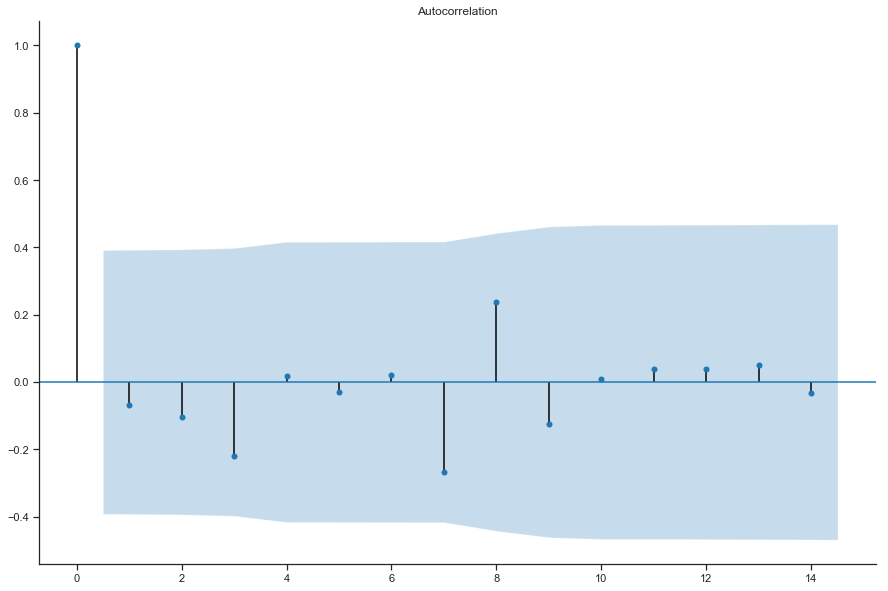

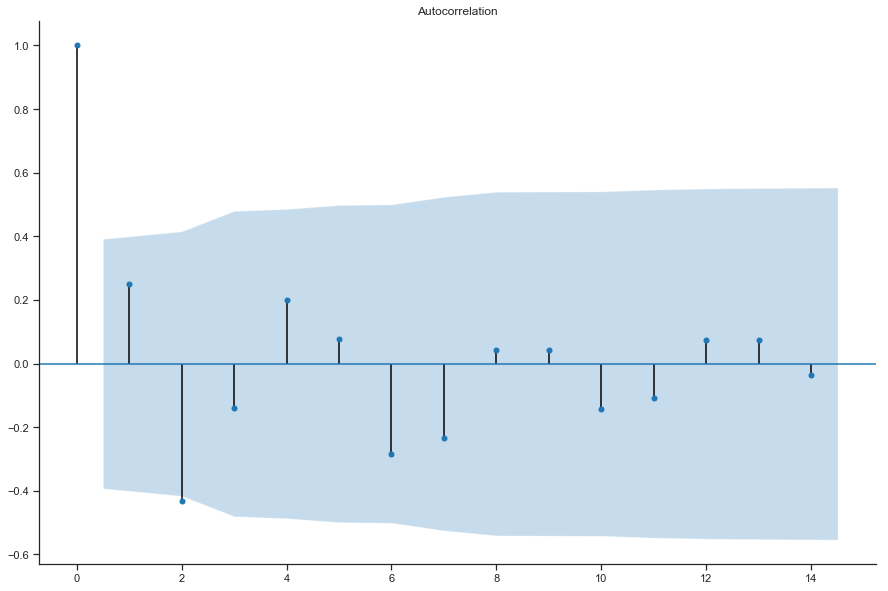

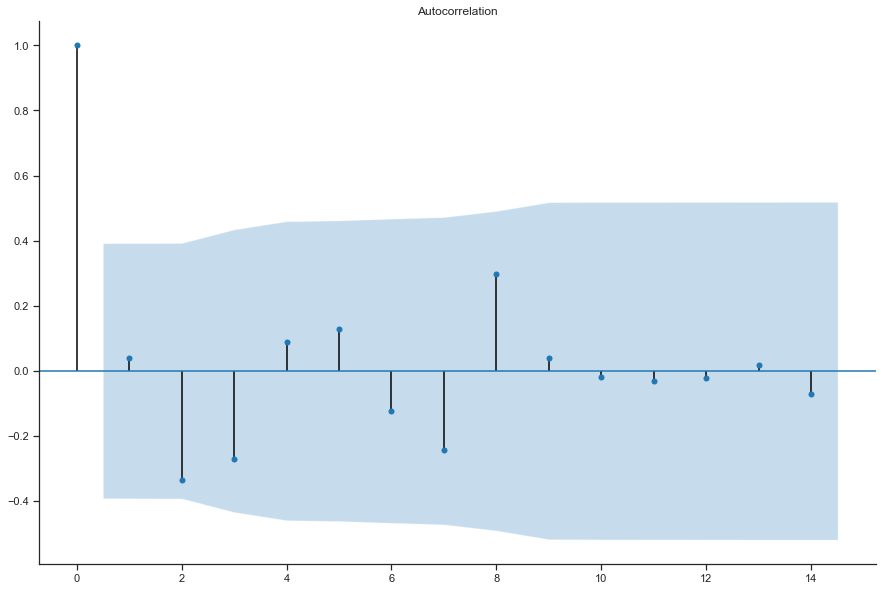

In [63]:
correlogram_plot(resid_pos)
correlogram_plot(resid_pre)
correlogram_plot(resid_total)

Plotting histogram (in blue) and kernel density estimation (in black) for the residuals

In [69]:
def hist(series):
    fig, ax= plt.subplots();
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': 'mediumseagreen'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x175442508d0>)

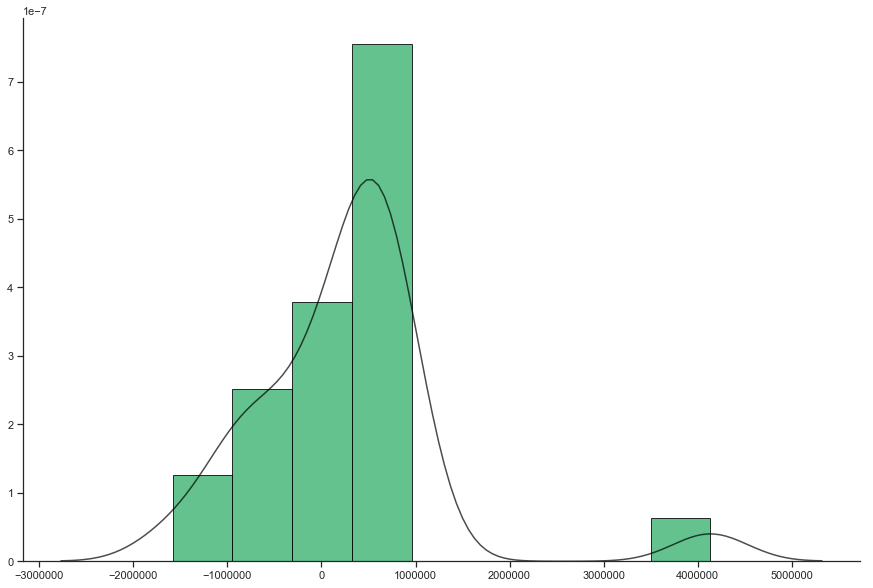

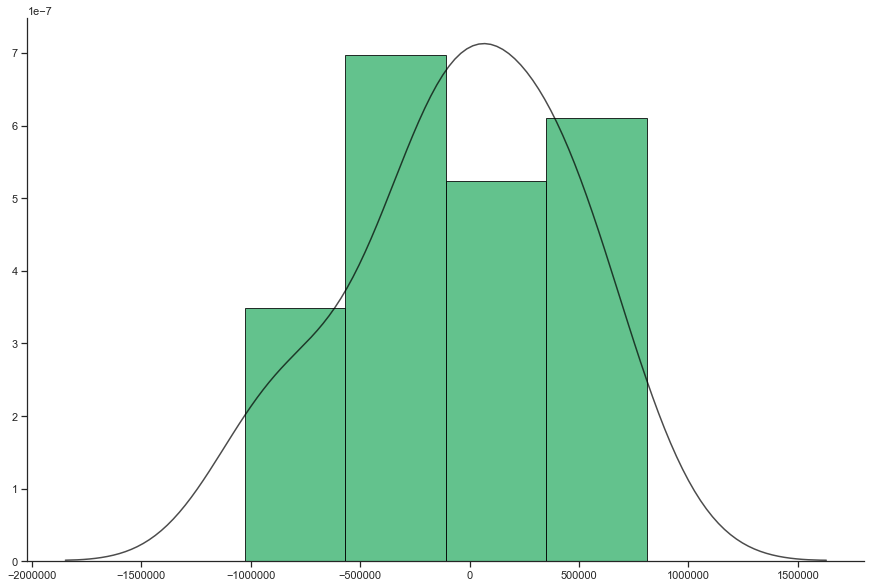

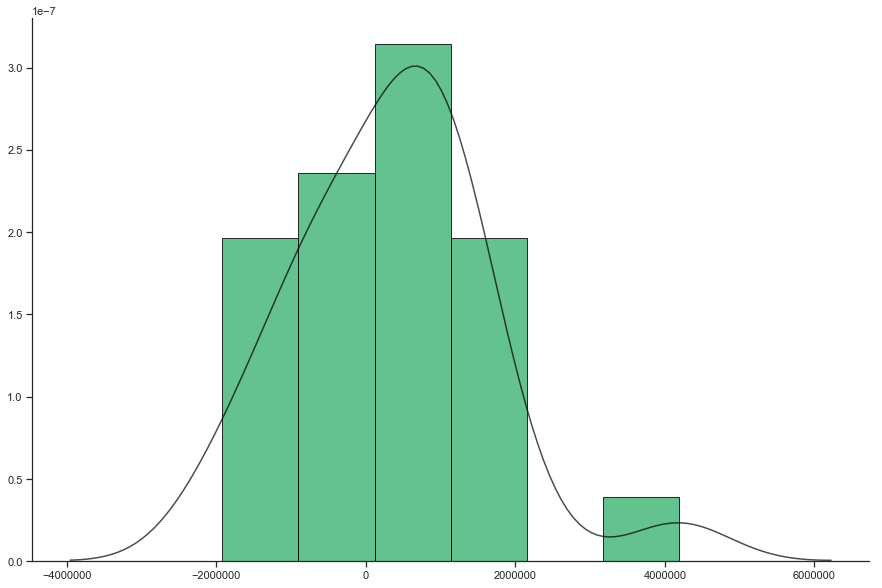

In [70]:
hist(resid_pos)
hist(resid_pre)
hist(resid_total)

## Model validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods to our dataset.

In [75]:
data

,mins_pos_pay,mins_pre_pay,total_mins
date,,,
2013Q1,8785943,6582117,15368060
2013Q2,9512689,7108640,16621329
2013Q3,10315484,7335154,17650638
2013Q4,9809515,6250549,16060064
2014Q1,10128751,5799223,15927974
2014Q2,10821463,6438071,17259534
2014Q3,11524344,7179152,18703495
2014Q4,11997330,7147630,19144961
2015Q1,10273637,6480172,16753809


In [87]:
# Real time forecasting - use it as a template - expanding window

def validation_func(y, from_date):
    validation=from_date.index
    start = y.index.get_loc(from_date.index[0]) 
    
    pred1 = []
    pred2 = []
    actual= []
    for i in range(start, len(y)):
    
        actual.append(y.iloc[i]) # actual value
    
        pred1.append(y.iloc[i-1]) # random walk forecast
    
        model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
        pred2.append(model.forecast(1)[0]) # SES forecast

    columns=['RW', 'SES', 'Actual']
    results_sm = np.vstack([pred1,pred2,actual]).T
    return pd.DataFrame(results_sm, columns=columns, index=validation)

In [90]:
results_pos = validation_func(data['mins_pos_pay'], data['2017Q1':])
results_pre = validation_func(data['mins_pre_pay'], data['2017Q1':])
results_total = validation_func(data['total_mins'], data['2017Q1':])

We find that simple exponential smoothing generates more accurate forecasts. 

In [92]:
def rmse_se_model(results):
    table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
    for i in range(2):
        table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
        table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
    return table.round(3)

In [95]:
display(rmse_se_model(results_pos))
display(rmse_se_model(results_pre))
display(rmse_se_model(results_total))

,RMSE,SE
RW,786660.914,266525.249
SES,787546.878,266273.690


,RMSE,SE
RW,465233.076,163251.300
SES,633056.899,199078.025


,RMSE,SE
RW,1138575.635,390031.974
SES,1162316.651,398242.592


## Forecast

We show how to do expanding and rolling point forecast. 

In [115]:
def forecast_plot(h, y):
    w=h*3
    data = y
    model = sm.tsa.SimpleExpSmoothing
    pred_index = y.index[-1] + np.array(range(1,h+1))
    pred_rolling = pd.Series(0,index=pred_index)
    pred_expanding = pd.Series(0,index=pred_index)
    orig_fit = None
    orig_roll = None
    for i in range(0,h):
        current_exp = pd.concat([data, pred_expanding.head(i)])
        expanding = model(current_exp).fit()
        pred_expanding.update(expanding.forecast(1))
        current_roll = pd.concat([data, pred_rolling.head(i)])
        rolling = model(current_roll.tail(w)).fit()
        pred_rolling.update(rolling.forecast(1))
        if i==0:
            orig_fit = expanding.fittedvalues
            orig_roll = rolling.fittedvalues
    ax = data[-w:].plot();
    pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax);
    pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax);

C:\Users\Franco\Anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


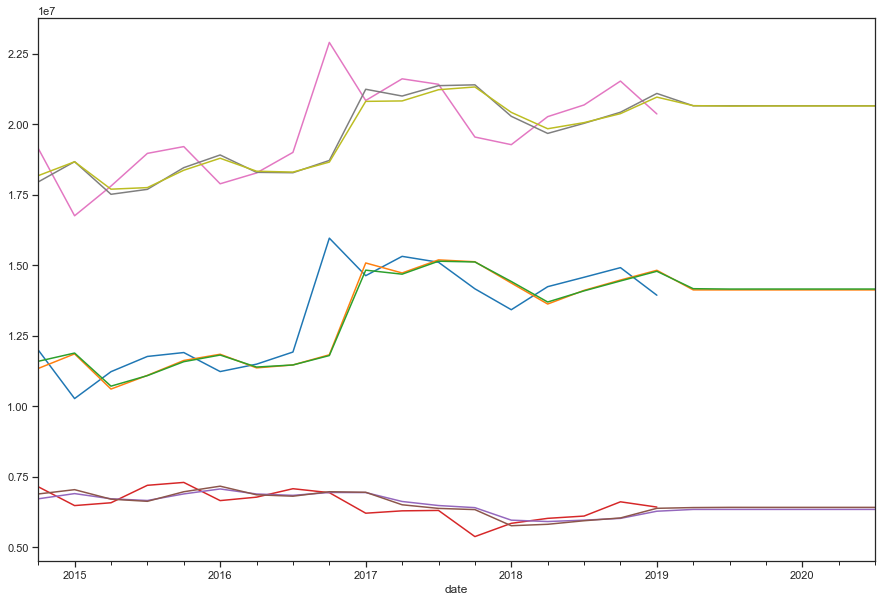

In [117]:
forecast_plot(6, data['mins_pos_pay'])
forecast_plot(6, data['mins_pre_pay'])
forecast_plot(6, data['total_mins'])

In this case, **statsmodels** doesn't provide interval forecast